# 1. File Import

In [1]:
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

#keras has to be imported before fastai
from keras.models import Sequential #import the Sequential model type from Keras. This is simply a linear stack of neural network layers, and it's perfect for the type of feed-forward CNN we're building in this tutorial.
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from fastai.imports import *
from fastai import *
from fastai.structured import *

Using TensorFlow backend.


In [2]:
df = pd.read_csv("C:/Users/Mark/Google Drive/python-files/Resources-and-courses/pandas-course/LV - all time data for ML.csv")

C:\Users\Mark\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176681 entries, 0 to 176680
Data columns (total 13 columns):
Search keyword        176681 non-null object
Day of week           176681 non-null object
Quality score         176681 non-null object
Ad final URL          176681 non-null object
Clicks                176681 non-null object
Impressions           176681 non-null object
CTR                   176681 non-null object
Avg. CPC              176681 non-null object
Cost                  176681 non-null object
Avg. position         176681 non-null float64
Conversions           176681 non-null float64
View-through conv.    176681 non-null int64
Conv. rate            176681 non-null object
dtypes: float64(2), int64(1), object(10)
memory usage: 17.5+ MB


# 2. Converting Formats: turning numeric data into floats

In [5]:
df = df.replace({'\$': '', ',': '', '%': '', '--': '0'}, regex=True) #remove commas, percentage and dollars from values
#note that I set -- to 0 for QS, but -- actually means where no QS is given, which is most of the cases!
#could also do: df['Quality score'] = df['Quality score'].replace({' ': '0'}, regex=True) #converting blank values on QS to 0

In [6]:
#convert back to floats now that we removed the non-numeric pieces
df.Clicks = df.Clicks.astype(float) #convert the 'Clicks' column to a float.
df.Impressions = df.Impressions.astype(float)
df.CTR = df.CTR.astype(float)
df['Quality score'] = df['Quality score'].astype(float)
df['Conv. rate'] = df['Conv. rate'].astype(float)
df.Cost = df.Cost.replace({'A': ''}, regex=True) # First removing A (AUD) from avg cpc column
df.Cost = df.Cost.astype(float) # then converting Cost into a float (after removing A)
df['Avg. CPC'] = df['Avg. CPC'].replace({'A': ''}, regex=True) #removing A (AUD) from avg cpc column
df['Avg. CPC'] = df['Avg. CPC'].astype(float)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176681 entries, 0 to 176680
Data columns (total 13 columns):
Search keyword        176681 non-null object
Day of week           176681 non-null object
Quality score         176681 non-null float64
Ad final URL          176681 non-null object
Clicks                176681 non-null float64
Impressions           176681 non-null float64
CTR                   176681 non-null float64
Avg. CPC              176681 non-null float64
Cost                  176681 non-null float64
Avg. position         176681 non-null float64
Conversions           176681 non-null float64
View-through conv.    176681 non-null int64
Conv. rate            176681 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 17.5+ MB


# 3. Exploring the data

<function matplotlib.pyplot.show(*args, **kw)>

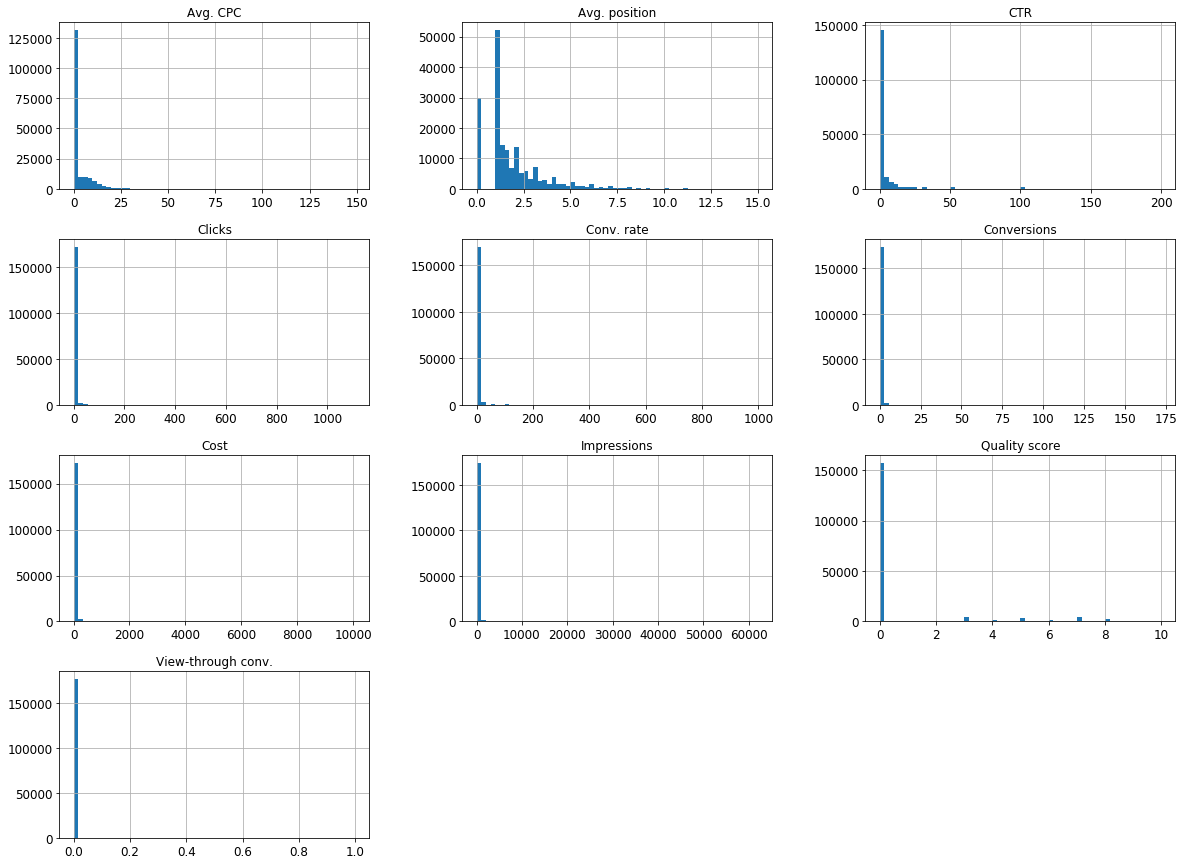

In [8]:
#visualise the data 
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 13 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
df.hist(bins=60, figsize=(20,15))
plt.show

In [9]:
df['Quality score'].value_counts()
#(df['Quality score'].value_counts() / 157211)*100 # as %can see that the QS data is highly skewed towards 0 QS  (157211 is the number of 0's)
# huge amount of values missing '0' - consider dropping this column in total

0.0     157211
7.0       4901
3.0       4194
5.0       3575
8.0       2448
6.0       1521
4.0       1067
1.0        723
2.0        710
10.0       219
9.0        112
Name: Quality score, dtype: int64

In [10]:
df['View-through conv.'].value_counts()  #pretty much no data, so we can drop in next cell

0    176679
1         2
Name: View-through conv., dtype: int64

In [11]:
df = df.drop('View-through conv.', axis=1)  #drop columns

In [12]:
#create correlation matrix to show what features correlate most closely with Conversions - but this should be done after encoding.
corr_matrix = df.corr()
corr_matrix.Conversions.sort_values(ascending=False)


Conversions      1.000000
Clicks           0.776911
Cost             0.746148
Impressions      0.510847
Conv. rate       0.232407
Avg. CPC         0.178050
Quality score    0.118352
CTR              0.040849
Avg. position   -0.022519
Name: Conversions, dtype: float64

In [13]:
#remove outliers

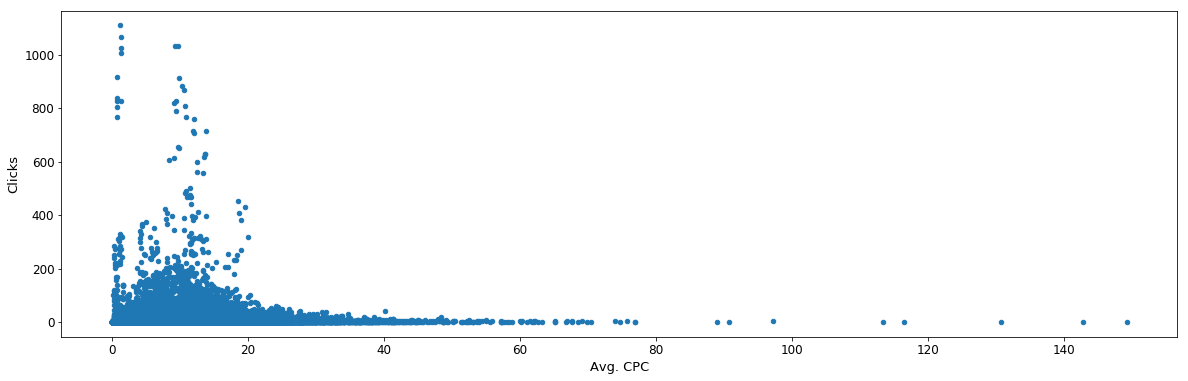

In [14]:
df.plot(kind='scatter', x='Avg. CPC', y='Clicks', figsize=(20,6))

In [15]:
#There are some very expensive clicks, that could be removed, anything above $120, as this is rare
df = df[df['Avg. CPC'] < 120]

In [16]:
df = df[df.Clicks != 0] #remove any values where clicks = 0

In [17]:
df = df.drop('Conv. rate', axis=1) #remove because it's not a level (we can't adjust it)

In [18]:
#looking to understand difference between clicks and cost (since clicks does better in RF as a predictor)

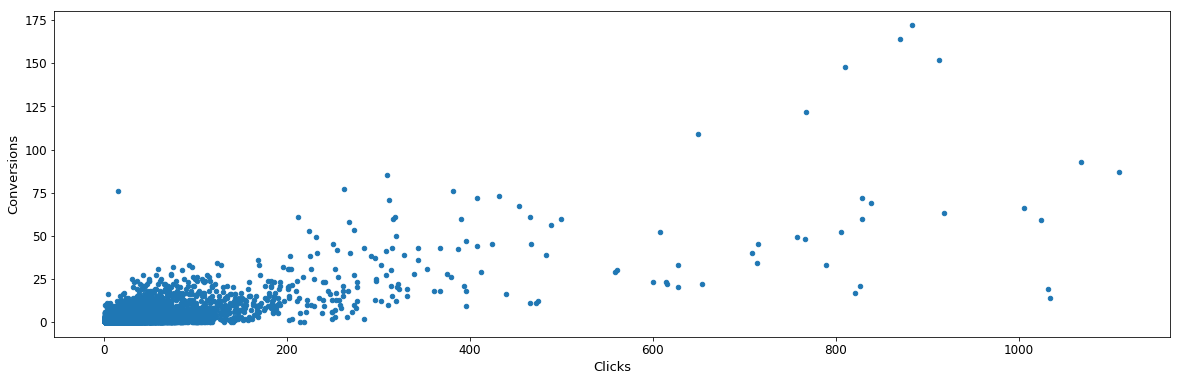

In [19]:
df.plot(kind='scatter', x='Clicks', y='Conversions', figsize=(20,6))

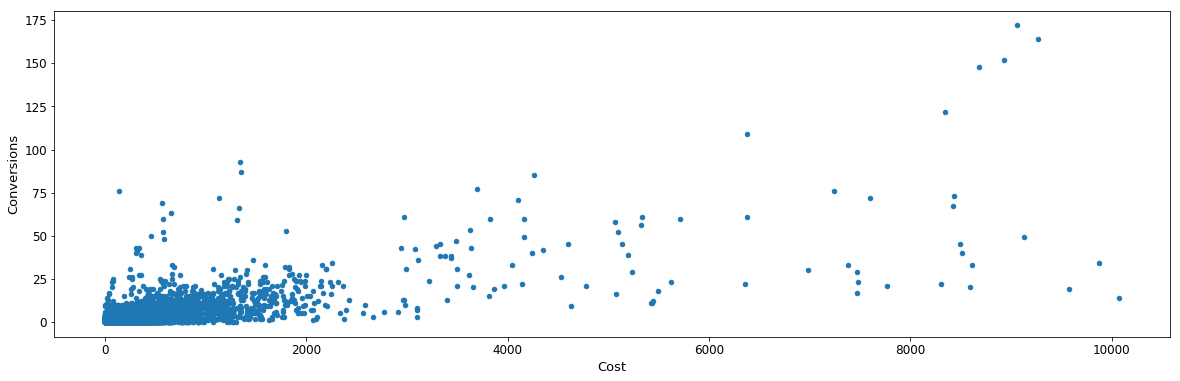

In [20]:
df.plot(kind='scatter', x='Cost', y='Conversions', figsize=(20,6))

In [21]:
df['Clicks'].corr(df['Cost']) #they are highly correlated as well

0.8459045656947298

In [22]:
df = df.drop('Clicks', axis=1)  #drop clicks, because 'Cost' is a better lever

In [23]:
#df = df.reset_index(drop=True)  #after removing a lot of rows above its good to reset the index, for joining the onehot encoding later on

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50997 entries, 1 to 176676
Data columns (total 10 columns):
Search keyword    50997 non-null object
Day of week       50997 non-null object
Quality score     50997 non-null float64
Ad final URL      50997 non-null object
Impressions       50997 non-null float64
CTR               50997 non-null float64
Avg. CPC          50997 non-null float64
Cost              50997 non-null float64
Avg. position     50997 non-null float64
Conversions       50997 non-null float64
dtypes: float64(7), object(3)
memory usage: 4.3+ MB


# 4. Fast RF

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50997 entries, 1 to 176676
Data columns (total 10 columns):
Search keyword    50997 non-null object
Day of week       50997 non-null object
Quality score     50997 non-null float64
Ad final URL      50997 non-null object
Impressions       50997 non-null float64
CTR               50997 non-null float64
Avg. CPC          50997 non-null float64
Cost              50997 non-null float64
Avg. position     50997 non-null float64
Conversions       50997 non-null float64
dtypes: float64(7), object(3)
memory usage: 4.3+ MB


In [26]:
df_fast = df.copy()

In [27]:
train_cats(df_fast)

In [28]:
dfproc, y , nas = proc_df(df_fast, 'Conversions', max_n_cat=None)
#note that we are imputing medium with proc_df

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfproc, y, test_size=0.2, random_state=42)

In [30]:
#fit random forest to the data
#set_rf_samples(3000)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=20, max_depth = 10, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True)

%time rf_fit = rf.fit(X_train, y_train)
rf_predict = rf_fit.predict(X_test) #predictions

#calculate Root Mean Squared Error for predictions 'rf_predict' against actuals 'y_test'
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, rf_predict)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe)

C:\Users\Mark\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Wall time: 689 ms
RMSQE:  1.4216295004777615


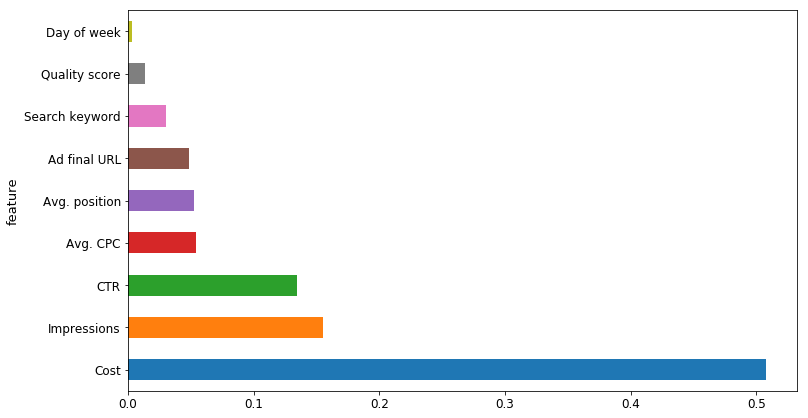

In [31]:
#----------feature importance

feat_labels = X_train.columns
importance = rf_fit.feature_importances_  #determing feature importance from the algorithm"

df_feat = pd.DataFrame(importance, index=feat_labels)
df_feat = df_feat.reset_index()
df_feat = df_feat.rename(index=str, columns={0: "importance", 'index': 'feature'})
df_feat = df_feat.sort_values('importance', ascending=False, inplace=False, axis=0)
df_feat.head(20)

#plotting feature importances
def plot_fi(df): 
  return df.plot('feature','importance','barh', figsize=(12,7), legend=False)
plot_fi(df_feat[:30]);

In [32]:
df_feat.head(20)

,feature,importance
7,Cost,0.507359
4,Impressions,0.155410
5,CTR,0.134655
6,Avg. CPC,0.054179
8,Avg. position,0.052401
3,Ad final URL,0.048871
0,Search keyword,0.030176
2,Quality score,0.013983
1,Day of week,0.002966


In [33]:
#4.1 predict average conversions for everything

In [34]:
X_train['Conversions'] = y_train.mean() #find the mean and create a new column in the training set.
X_train['Conversions'].head()

C:\Users\Mark\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


57080     0.651838
21661     0.651838
28733     0.651838
50580     0.651838
101337    0.651838
Name: Conversions, dtype: float64

In [35]:
y_test.shape

(10200,)

In [36]:
y_avg_cnt = X_train['Conversions'][:10200].values

In [37]:
mse = mean_squared_error(y_test, y_avg_cnt)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe) 

RMSQE:  2.9048680998592467


In [38]:
#so the RF is has a far lower RMSE then just predicting the average.

In [39]:
#4.2try this just for cost feature

In [40]:
dfcost = dfproc['Cost'].copy()
dfcost = dfcost.values.reshape(-1,1) # have to reshape the array if just 1 value for the algorithm,
#creating new split
X_train, X_test, y_train, y_test = train_test_split(dfcost, y, test_size=0.2, random_state=42) 

In [41]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=20, max_depth = 20, min_samples_leaf=6, max_features=0.5, n_jobs=-1, oob_score=True)

%time rf_fit = rf.fit(X_train, y_train)
rf_predict = rf_fit.predict(X_test) #predictions

#calculate Root Mean Squared Error for predictions 'rf_predict' against actuals 'y_test'
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, rf_predict)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe)

C:\Users\Mark\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Wall time: 537 ms
RMSQE:  2.0524834763104316


In [42]:
#linear regression with cost

In [43]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr_fit = lr.fit(X_train, y_train)
lr_predict = lr_fit.predict(X_test) #predictions

#calculate Root Mean Squared Error for predictions 'rf_predict' against actuals 'y_test'
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, lr_predict)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe)


RMSQE:  2.021127479976802


# 5. Neural Network

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50997 entries, 1 to 176676
Data columns (total 10 columns):
Search keyword    50997 non-null object
Day of week       50997 non-null object
Quality score     50997 non-null float64
Ad final URL      50997 non-null object
Impressions       50997 non-null float64
CTR               50997 non-null float64
Avg. CPC          50997 non-null float64
Cost              50997 non-null float64
Avg. position     50997 non-null float64
Conversions       50997 non-null float64
dtypes: float64(7), object(3)
memory usage: 4.3+ MB


In [84]:
df_nn = df.copy()

In [85]:
train_cats(df_nn)

In [86]:
#proc_df but this time with a scaler (this is like min/max scaler to make all values between 0 & 1 which is much better for gradient descent & other optimizers)
#there is no need to scale the target variable (y)
dfproc, y , nas, mapper = proc_df(df_nn, 'Conversions', do_scale=True) #added the scaling, since this is important for neural networks
#we could've also scaled the x_train, y_train data after proc_df, but this is easier as they are all together

In [87]:
X_train, X_test, y_train, y_test = train_test_split(dfproc, y, test_size=0.2, random_state=42)

In [88]:
from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [89]:
#create the NN model & compile

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(400, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(200, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(200, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(100, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal')) #,activation='linear' is often used for regression 

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', rmse])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 400)               4000      
_________________________________________________________________
dense_10 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_11 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 144,601
Trainable params: 144,601
Non-trainable params: 0
_________________________________________________________________


In [90]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='mean_squared_error', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='mean_squared_error', save_best_only=True)]
#patience is the number of epochs to look back for non-improvement.
#modelcheckpoint saves the best perfoming epoch rather then the one it finished on
#well explained here: https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/

In [91]:
%time history = NN_model.fit(X_train,y_train, epochs=200, batch_size=15, callbacks=callbacks, validation_split = 0.2, verbose=2) 


Train on 32637 samples, validate on 8160 samples
Epoch 1/200
 - 5s - loss: 10.7797 - mean_squared_error: 10.7797 - mean_absolute_error: 1.0845 - rmse: 1.0845 - val_loss: 10.4188 - val_mean_squared_error: 10.4188 - val_mean_absolute_error: 0.8958 - val_rmse: 0.8958
Epoch 2/200
 - 5s - loss: 9.7818 - mean_squared_error: 9.7818 - mean_absolute_error: 0.9547 - rmse: 0.9547 - val_loss: 11.1352 - val_mean_squared_error: 11.1352 - val_mean_absolute_error: 0.8855 - val_rmse: 0.8855
Epoch 3/200
 - 5s - loss: 9.7420 - mean_squared_error: 9.7420 - mean_absolute_error: 0.9737 - rmse: 0.9737 - val_loss: 11.0064 - val_mean_squared_error: 11.0064 - val_mean_absolute_error: 0.9480 - val_rmse: 0.9480
Epoch 4/200
 - 6s - loss: 9.6330 - mean_squared_error: 9.6330 - mean_absolute_error: 0.9739 - rmse: 0.9739 - val_loss: 11.1371 - val_mean_squared_error: 11.1371 - val_mean_absolute_error: 0.8844 - val_rmse: 0.8844
Epoch 5/200
 - 6s - loss: 9.6804 - mean_squared_error: 9.6804 - mean_absolute_error: 0.9591 -

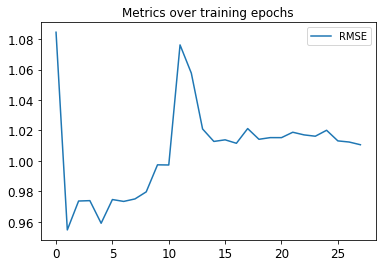

In [92]:
pyplot.plot(history.history['rmse'], label='RMSE')
plt.title('Metrics over training epochs')
plt.legend()
pyplot.show()

In [93]:
predictions = NN_model.predict(X_test)  #for classification it would be model.predict_classes(Xnew)
print(predictions)

[[0.67962]
 [0.67962]
 [0.67962]
 ...
 [0.67962]
 [0.67962]
 [0.67962]]


In [94]:
score = NN_model.evaluate(X_test, y_test, verbose=0)
print(score)

[8.424608365133697, 8.424608365133697, 1.0208524174316256, 1.0208524170576356]


In [95]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmsqe = np.sqrt(mse)
print("MSE: ", mse)
print("RMSQE: ", rmsqe)

MSE:  8.424608249745468
RMSQE:  2.9025175709623996


In [50]:
#try a shallower model
#create the NN model & compile

#keras.backend.clear_session() #dont think you need it but I put it here just in case.
    
NN_model2 = Sequential()

# The Input Layer :
NN_model2.add(Dense(100, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layer :
NN_model2.add(Dense(100, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model2.add(Dense(1, kernel_initializer='normal')) #,activation='linear' #i think you use sigmoid on last layer if its a classifier

# Compile the network :
NN_model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', rmse])
NN_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 11,301
Trainable params: 11,301
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='mean_squared_error', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='mean_squared_error', save_best_only=True)]
#patience is the number of epochs to look back for non-improvement.
#modelcheckpoint saves the best perfoming epoch rather then the one it finished on
#well explained here: https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/

In [52]:
%time history = NN_model.fit(X_train,y_train, epochs=200, batch_size=15, callbacks=callbacks, validation_split = 0.2, verbose=2) 


Train on 32637 samples, validate on 8160 samples
Epoch 1/200
 - 5s - loss: 9.7901 - mean_squared_error: 9.7901 - mean_absolute_error: 1.0205 - rmse: 1.0205 - val_loss: 11.2255 - val_mean_squared_error: 11.2255 - val_mean_absolute_error: 1.0249 - val_rmse: 1.0249
Epoch 2/200
 - 5s - loss: 9.7564 - mean_squared_error: 9.7564 - mean_absolute_error: 1.0121 - rmse: 1.0121 - val_loss: 11.2234 - val_mean_squared_error: 11.2234 - val_mean_absolute_error: 1.0303 - val_rmse: 1.0303
Epoch 3/200
 - 5s - loss: 9.7919 - mean_squared_error: 9.7919 - mean_absolute_error: 1.0185 - rmse: 1.0185 - val_loss: 11.2182 - val_mean_squared_error: 11.2182 - val_mean_absolute_error: 1.0271 - val_rmse: 1.0271
Epoch 4/200
 - 5s - loss: 9.7887 - mean_squared_error: 9.7887 - mean_absolute_error: 1.0133 - rmse: 1.0133 - val_loss: 11.2187 - val_mean_squared_error: 11.2187 - val_mean_absolute_error: 1.0354 - val_rmse: 1.0354
Epoch 5/200
 - 5s - loss: 9.7867 - mean_squared_error: 9.7867 - mean_absolute_error: 1.0139 - r

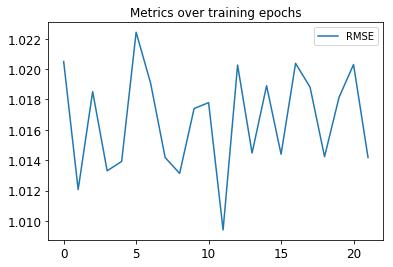

In [53]:
pyplot.plot(history.history['rmse'], label='RMSE')
plt.title('Metrics over training epochs')
plt.legend()
pyplot.show()

In [54]:
score = NN_model.evaluate(X_test, y_test, verbose=0)
print(score)

[8.418758680703593, 8.418758680703593, 0.9984273594968459, 0.9984273511288213]


In [55]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmsqe = np.sqrt(mse)
print("MSE: ", mse)
print("RMSQE: ", rmsqe)

MSE:  8.426399742942337
RMSQE:  2.90282616478189
